# Predictive Maintenance: Time Series

## Predictive Maintenance: detect faults from sensors with CRNN and Spectrograms

**Apply deeplearning and spectrogram transformations to prevent failures.**

We will apply a Predictive Maintenance task with the adoption of a deep learning architecture to deal with a high-frequency sequence of data which we preprocessed with Spectrograms. This step enable us to adopt a particular neural network structure known as **Convolution Recurrent Neural Network**, which learns at the same time from the spatial and recurrent structure of our data.

### The Data

The data is compose of a hydraulic pipeline under pressure conditions, in order to track the activity status of a particular part of the system. *The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connectd via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) es quantitatively varied.*

Now our scope is always to develop a ML solution that is able to detect faults, but we are interested to deal with high-frequency data. So we make use of the pressure data sampled at 100 Hz (6000 attributes per sensor: 6 in total) to build a model which classifies the status of the Accumulator in four classes (optimal pressure, slightly reduced pressure, severly reduced pressure, close to total failure).

In [2]:
import tqdm
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import librosa, librosa.display

In [3]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [4]:
### READ AND CONCAT DATA ###

label = pd.read_csv('profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = ['PS1.txt','PS2.txt','PS3.txt','PS4.txt','PS5.txt','PS6.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)

print(df.shape)
df.head()

/tmp/ipykernel_23455/409482929.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
/tmp/ipykernel_23455/409482929.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
/tmp/ipykernel_23455/409482929.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
/tmp/ipykernel_23455/409482929.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
/tmp/ipykernel_23455/409482929.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
/tmp/ipykernel_

(13230, 6000)


,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,151.16,151.19,151.25,151.16,151.10,151.16,151.14,151.10,151.21,151.19
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,150.82,150.82,150.86,150.80,150.73,150.79,150.84,150.79,150.80,150.86
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,150.49,150.44,150.47,150.46,150.38,150.47,150.50,150.43,150.54,150.62
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,150.34,150.30,150.28,150.38,150.41,150.33,150.31,150.31,150.25,150.28
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,150.31,150.20,150.17,150.28,150.31,150.25,150.27,150.22,150.13,150.19


In [5]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 6000, 6)

### Spectogram Transformation

The first step to deal with this kind of raw data involves an adequate preprocess phase. The data are just into fixed and equal labeled sequences, our duty is to extract value from this source of information. As introduced previously, we adopt **Spectograms** to preprocess these signal pieces and feed a CRNN. Spectrograms are time-frequency portraits of signals. They are a plot intensity of the frequency content of the signal as time progresses. They are widely adopted in the audio process/classification and are useful to us for their ability to map the data behaviors in a high-frequency domain. To apply spectrogram transformations we have to first reduce the magnitude of our series; a simple differentiation plus a proper clip to limit extreme variations, sounds good.

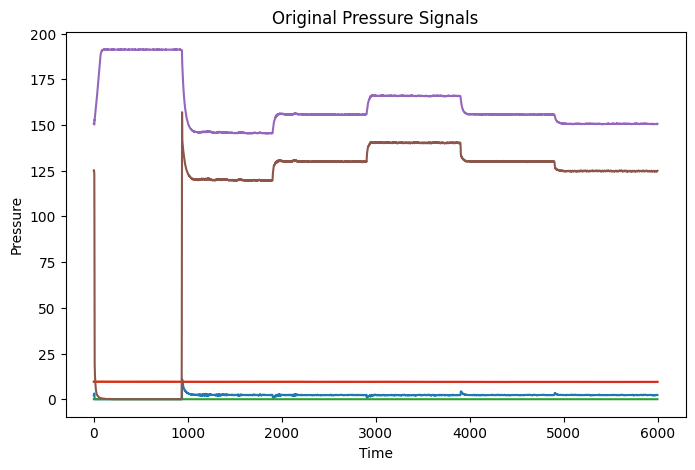

In [6]:
### PLOT ORIGINAL PRESSURE DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Original Pressure Signals')
plt.ylabel('Pressure'); plt.xlabel('Time')
np.set_printoptions(False)

In [11]:
### APPLY CLIPPING AND FIRST ORDER DIFFERECE ###

df = np.clip(np.diff(df, axis=1), -5,5)
df.shape

(2205, 5999, 6)

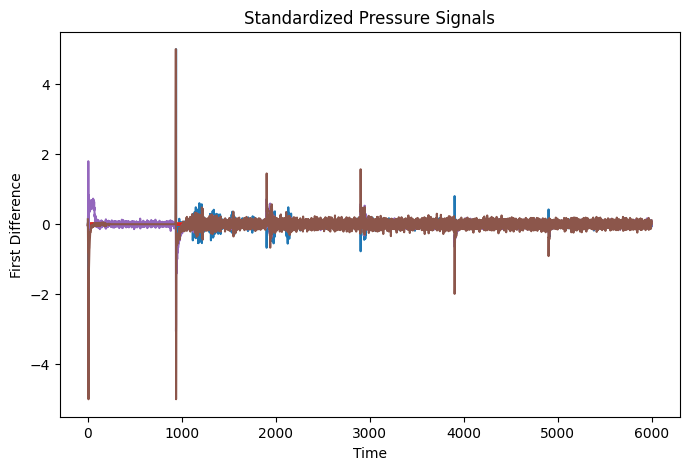

In [12]:
### PLOT STANDARDIZED DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Standardized Pressure Signals')
plt.ylabel('First Difference'); plt.xlabel('Time')
np.set_printoptions(False)

In [13]:
### LABEL DISTRIBUTION ###

label = label.Accumulator
label.value_counts()

90     808
130    599
115    399
100    399
Name: Accumulator, dtype: int64

In [14]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{130: 0, 115: 1, 100: 2, 90: 3}
{0: 130, 1: 115, 2: 100, 3: 90}


In [15]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

Compute spectrograms in python is quite easy; a good library which provides this functionality is Librosa. A transformation is operated for every pressure series at our disposal, so we ended with a sequence of 6 spectrograms for every sample instead of a sequence of raw signals.

In [21]:
### APPLY SPECTROGRAM TRANSFORMATION FOR EACH PRESSURE SIGNAL ###

df_spectre = []

for i,sample in enumerate(tqdm.tqdm(df)):
    
    sample_spectre = np.apply_along_axis(lambda x: librosa.feature.melspectrogram(y=x,sr=40000) ,0, sample)
    df_spectre.append(sample_spectre)
    
df_spectre = np.asarray(df_spectre)
df_spectre.shape

100%|██████████| 2205/2205 [13:58<00:00,  2.63it/s]


(2205, 128, 12, 6)

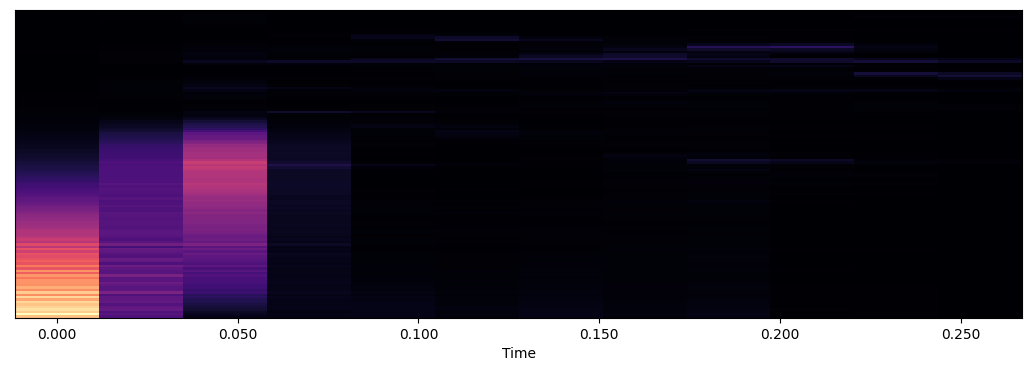

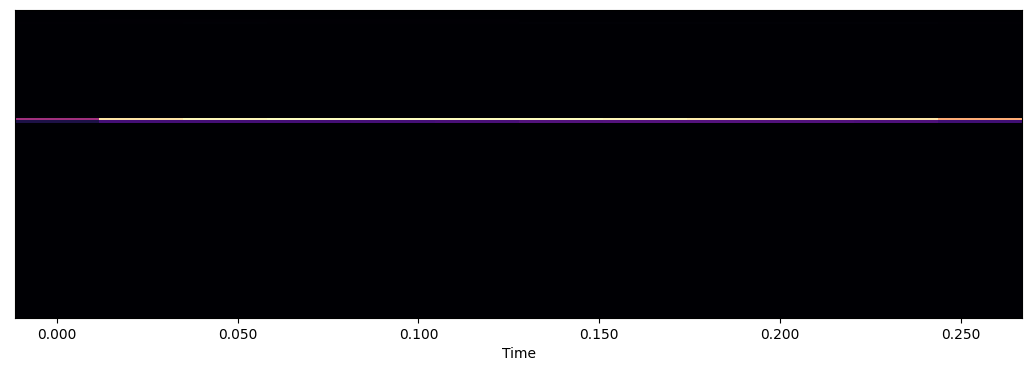

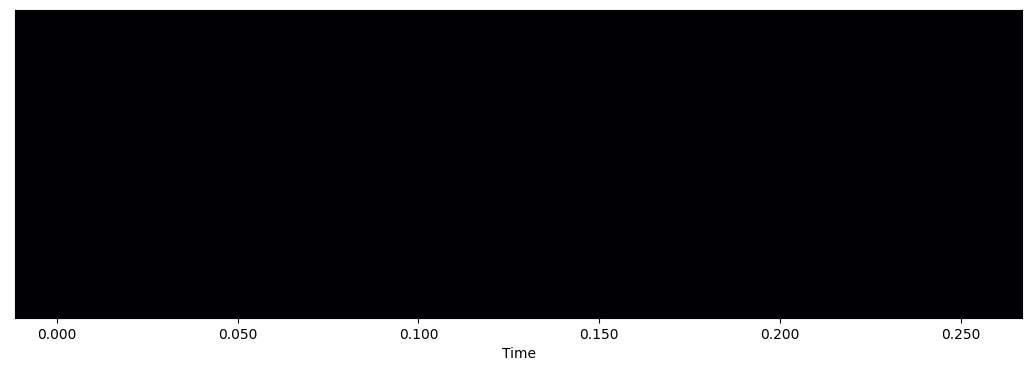

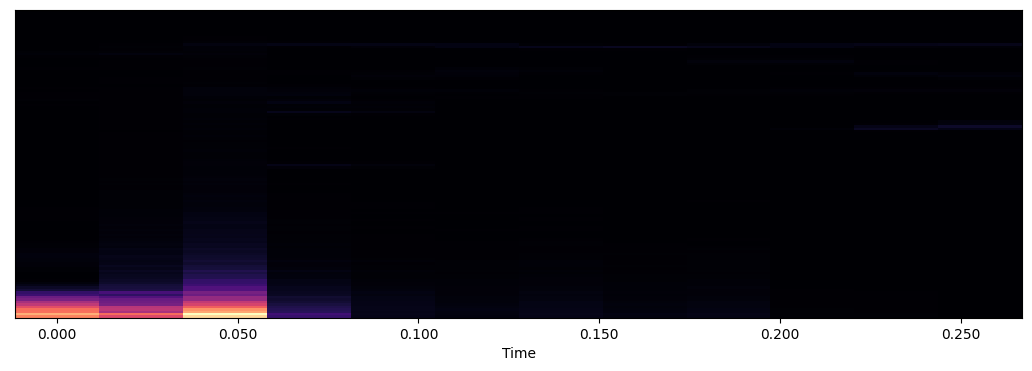

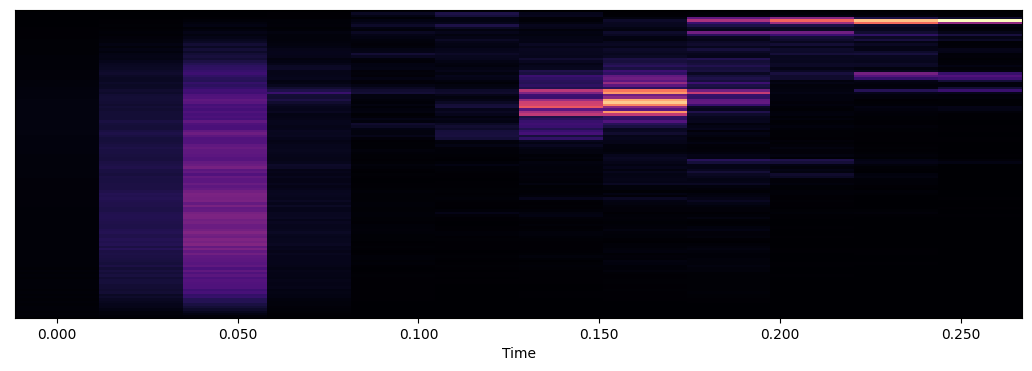

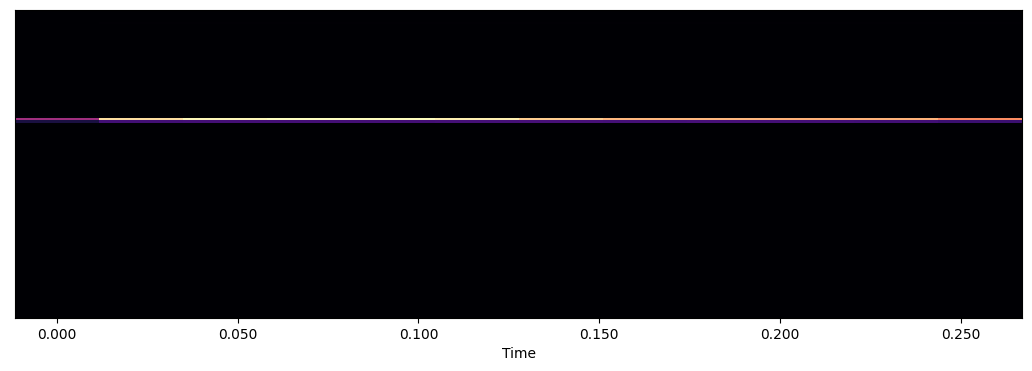

In [22]:
### EXEMPLE OF TRANSFORMED SAMPLE (6 DIFFERENT PRESSURE SIGNALS) ###

for i in range(len(data)):
    plt.figure(figsize=(13, 4))
    librosa.display.specshow(df_spectre[20][:,:,i], x_axis='time')

### The Model

Convolutional and Recurrent Neural Networks are the most common and powerful structure to build deep learning models. CNNSs and RNNs are not mutually exclusive, as both can perform classification of image and text inputs, creating an oportunity to combine the network types for increased effectiveness. This is especially true if the input to be classified is visually complex with added temporal characteristics that a CNN alone would be unable to process. 

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*EbnI4rU5NbgR_1HB.png)

Inputs are first processed by CNN layers whose outputs are then fed to RNN layers. These hybrid architectures are being explored for applications like video scene labeling, Optical Character Recognition, or audio classification. For our analysis, we feed CRNN with spectograms we have previously generated, to detect the working status of the Accumulator in our hydraulic pipeline. Each observation is now composed of stacked spectograms (6 in total, one for each pressure signal) 

In [23]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df_spectre, y, random_state = 42, test_size=0.2)

In [24]:
### DEFINE CRNN ###

def get_model(data):
    
    inp = Input(shape=(data.shape[1], data.shape[2], data.shape[3]))
    
    x = Conv2D(filters = 64, kernel_size=(2, 2), padding='same')(inp)
    
    x = Permute((2, 3, 1))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Permute((3, 1, 2))(x)
    # equal to BatchNormalization(axis=1)
    
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)
    
    x = Permute((2, 3, 1))(x)
    x = Reshape((data.shape[2], 64*64))(x)

    x = Bidirectional(GRU(64, activation='relu', return_sequences=False))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(y_train.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In the first stage, the network extracts convolution features from spectrogram plots, preserving the structure frequency x time x n_features. When we pass to the recurrent part, we need to reshape our data in the format time x n_features: time is the same dimension we observe in the convolutional level and spectrograms; the new n_features is the result of the flattering operation computed on the convolutional n_features and frequency.

In [25]:
model = get_model(X_train)

model.summary()

2023-04-01 01:50:07.184117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 12, 6)]      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 12, 64)       1600      
                                                                 
 permute (Permute)           (None, 12, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 12, 64, 128)      512       
 ormalization)                                                   
                                                                 
 permute_1 (Permute)         (None, 128, 12, 64)       0         
                                                                 
 activation (Activation)     (None, 128, 12, 64)       0         
                                                             

In [26]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=15)

model = get_model(X_train)
model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, validation_split=0.1, callbacks=[es])

2023-04-01 01:50:27.859222: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 58503168 exceeds 10% of free system memory.


Epoch 1/100


2023-04-01 01:50:36.626728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2023-04-01 01:50:37.642429: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2023-04-01 01:50:38.535220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2023-04-01 01:50:38.924585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


7/7 - 66s - loss: 1.4934 - accuracy: 0.3308 - val_loss: 1.5786 - val_accuracy: 0.3898 - 66s/epoch - 9s/step
Epoch 2/100
7/7 - 38s - loss: 1.1306 - accuracy: 0.5117 - val_loss: 1.2407 - val_accuracy: 0.5028 - 38s/epoch - 5s/step
Epoch 3/100
7/7 - 29s - loss: 0.9633 - accuracy: 0.5835 - val_loss: 1.1431 - val_accuracy: 0.5198 - 29s/epoch - 4s/step
Epoch 4/100
7/7 - 46s - loss: 0.8799 - accuracy: 0.6018 - val_loss: 0.9931 - val_accuracy: 0.5537 - 46s/epoch - 7s/step
Epoch 5/100
7/7 - 50s - loss: 0.8077 - accuracy: 0.6377 - val_loss: 0.9812 - val_accuracy: 0.5593 - 50s/epoch - 7s/step
Epoch 6/100
7/7 - 28s - loss: 0.7740 - accuracy: 0.6515 - val_loss: 0.9124 - val_accuracy: 0.6271 - 28s/epoch - 4s/step
Epoch 7/100
7/7 - 24s - loss: 0.7196 - accuracy: 0.6919 - val_loss: 0.8857 - val_accuracy: 0.6328 - 24s/epoch - 3s/step
Epoch 8/100
7/7 - 25s - loss: 0.6835 - accuracy: 0.7114 - val_loss: 0.8113 - val_accuracy: 0.6384 - 25s/epoch - 4s/step
Epoch 9/100
7/7 - 29s - loss: 0.6641 - accuracy: 0.7

In [27]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model.predict(X_test), axis=1)

14/14 [==============================] - 7s 121ms/step


In [28]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

          90       0.84      0.83      0.83       152
         100       0.62      0.68      0.65        75
         115       0.75      0.74      0.74        91
         130       0.91      0.89      0.90       123

    accuracy                           0.80       441
   macro avg       0.78      0.78      0.78       441
weighted avg       0.80      0.80      0.80       441



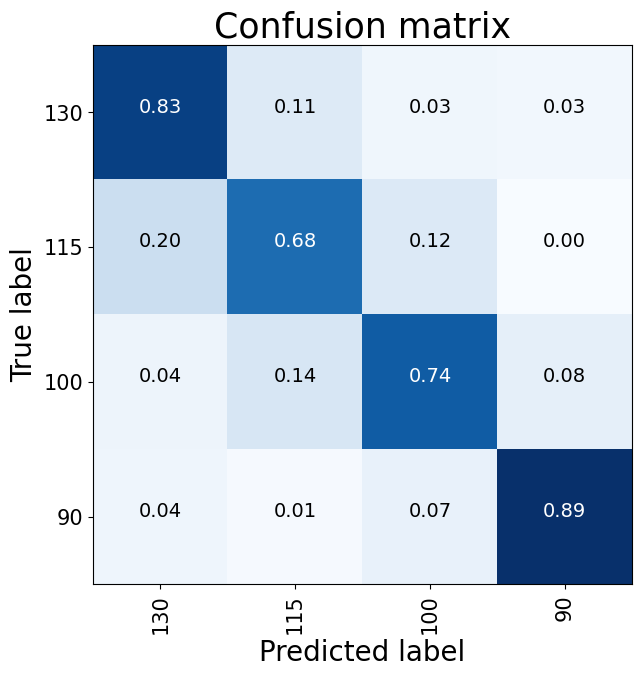

In [29]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()